In [1]:
import cv2
import numpy as np
import glob


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [39]:
def calibrate_camera(objpoints, imgpoints, calibration_image):
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    return (ret, mtx, dist, rvecs, tvecs)  

def undistort_image(image, mtx, dist):    
    undistorted_image = cv2.undistort(image, mtx, dist, None, mtx)
    return undistorted_image

def getWarpMatrixes():
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    return M, M_inv

def warp_perspective(undistored_image, M):
    img_size = (undistored_image.shape[1], undistored_image.shape[0])

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(undistored_image, M, img_size)

    # Return the resulting image and matrix
    return warped

def plot_two_images_side_by_side(image1, image2, title1, title2, cmap):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(image1, cmap))
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(cv2.cvtColor(image2, cmap))
    ax2.set_title(title2, fontsize=30)
    
def plot_images_side_by_side(images, titles, cmaps):
    f, axis = plt.subplots(1, len(images), figsize=(20,10))
    for idx, ax in enumerate(axis):
        if cmaps[idx] == 'gray':
            axis[idx].imshow(images[idx], cmap='gray')
        else:
            axis[idx].imshow(images[idx])
        ax.set_title(titles[idx])
    
M, M_inv = getWarpMatrixes()

In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

In [4]:
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)

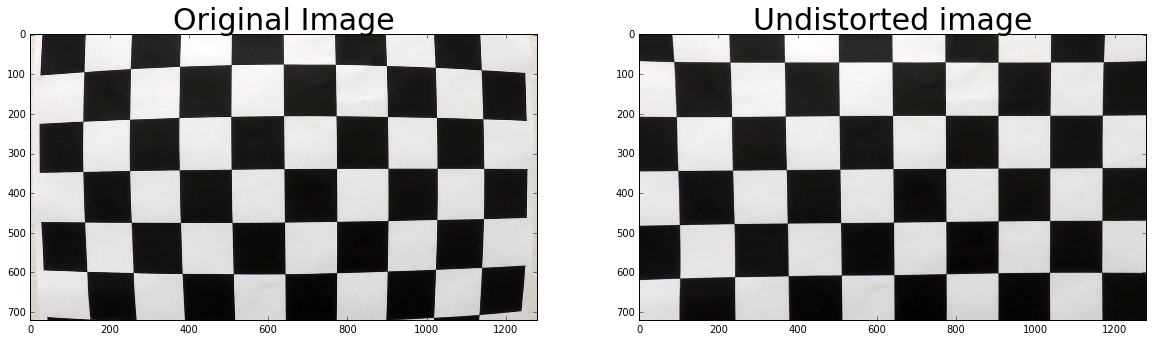

In [5]:
calib_image_name = 'camera_cal/calibration1.jpg'      
ret, mtx, dist, rvecs, tvecs = calibrate_camera(objpoints, imgpoints, calib_image_name)
img = cv2.imread(calib_image_name)
undistort_img = undistort_image(img, mtx, dist) 
plot_two_images_side_by_side(img, undistort_img, 'Original Image', 'Undistorted image', cv2.COLOR_BGR2RGB)

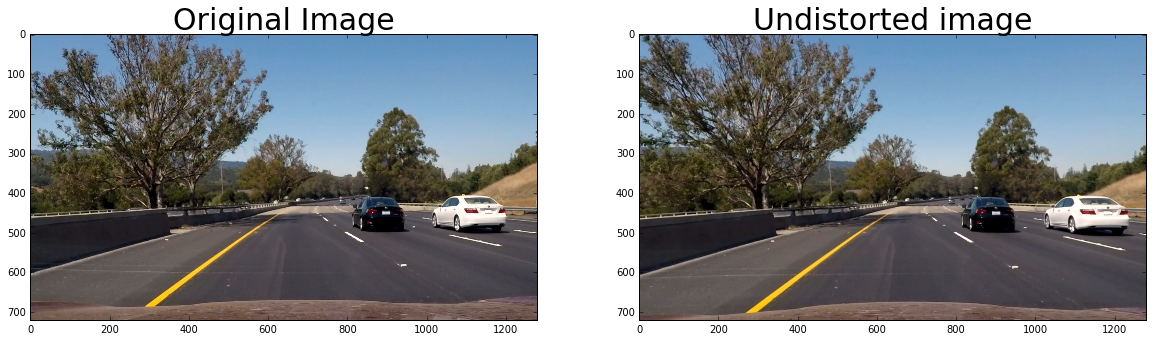

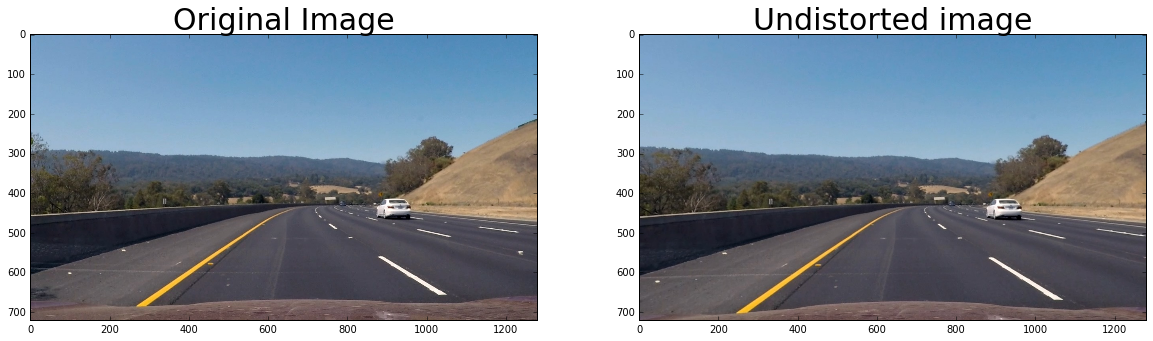

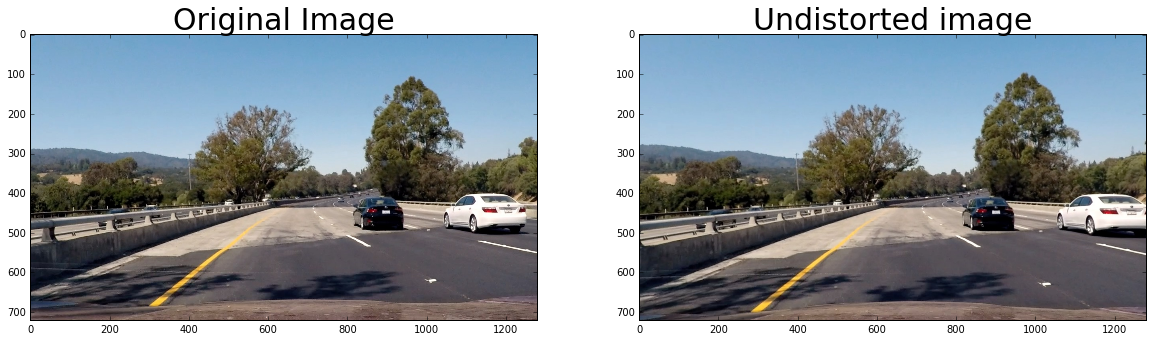

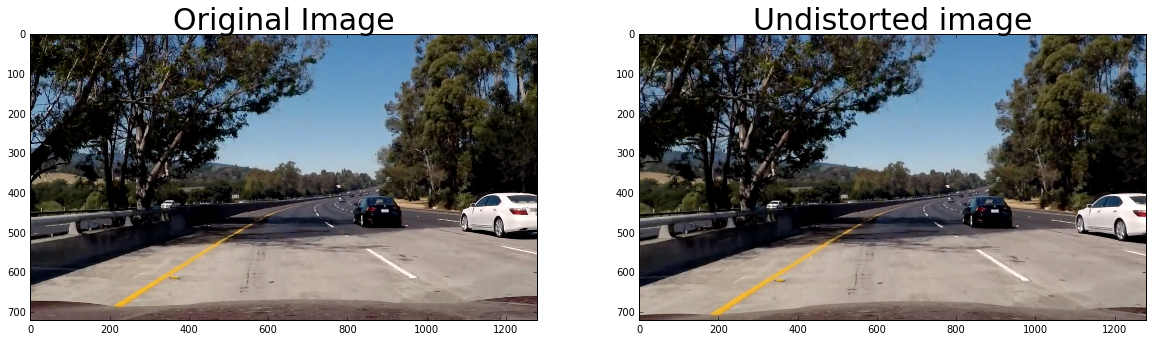

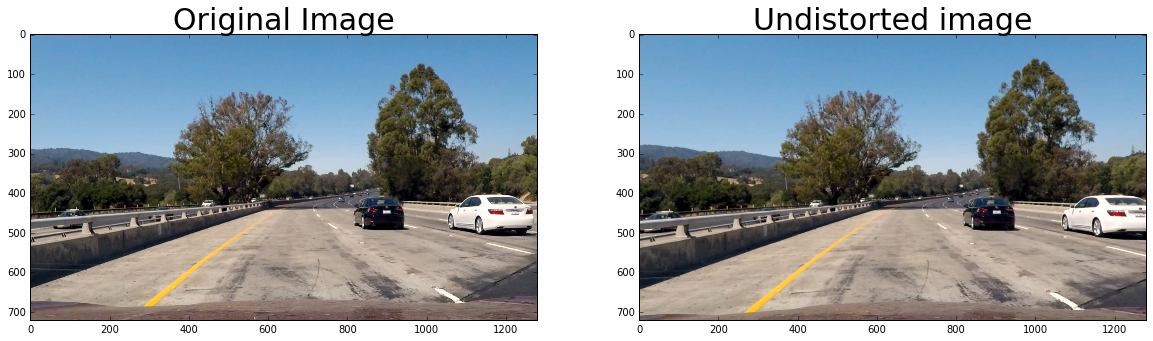

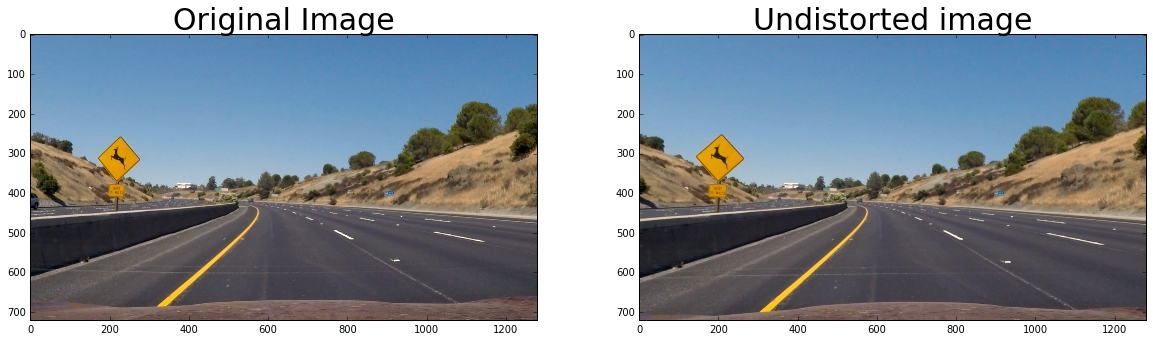

In [6]:
images = glob.glob('test_images/test*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    undistorted_image = undistort_image(image, mtx, dist)
    plot_two_images_side_by_side(image, undistorted_image, 'Original Image', 'Undistorted image', cv2.COLOR_BGR2RGB)

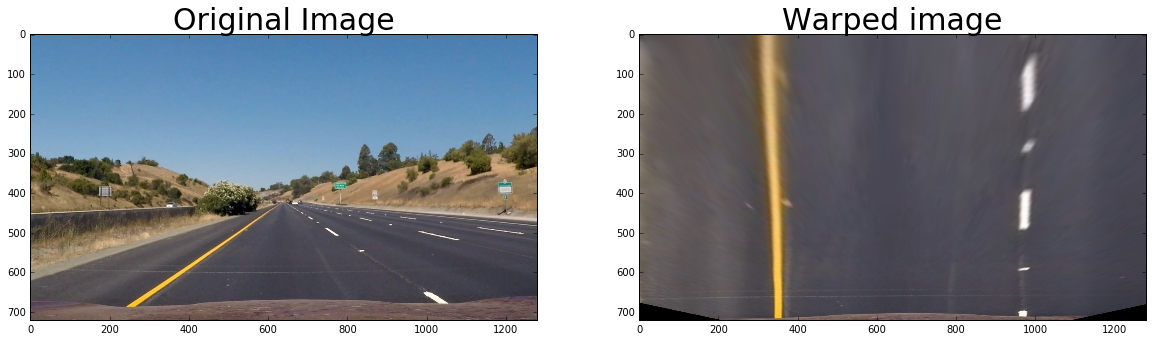

In [128]:
calib_image_name = 'test_images/straight_lines1.jpg'
image = cv2.imread(calib_image_name)
undistort_img = undistort_image(image, mtx, dist)
warped_image = warp_perspective(undistort_img, M)
plot_two_images_side_by_side(image, warped_image, 'Original Image', 'Warped image', cv2.COLOR_BGR2RGB)

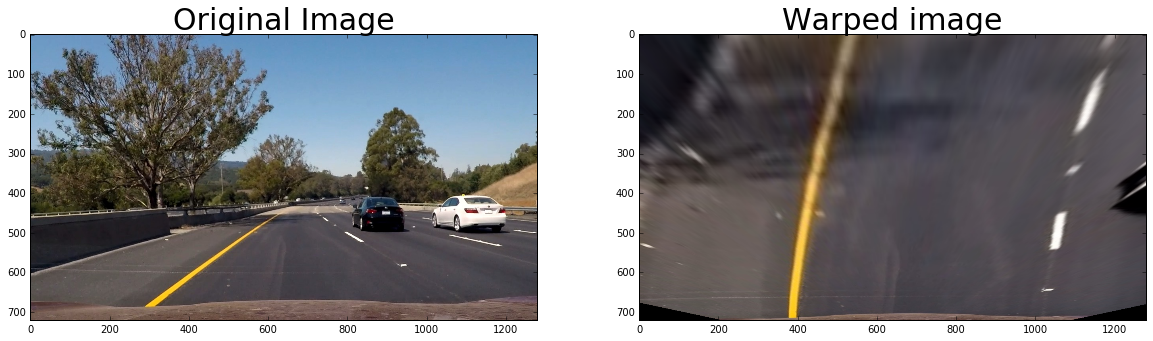

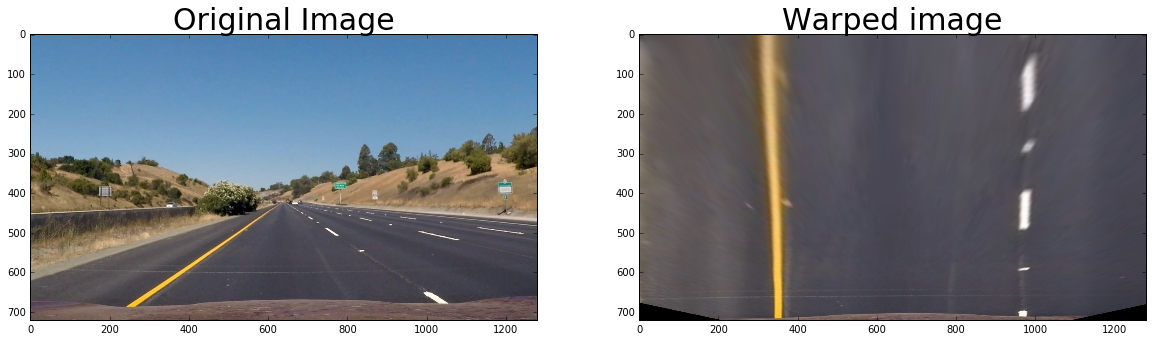

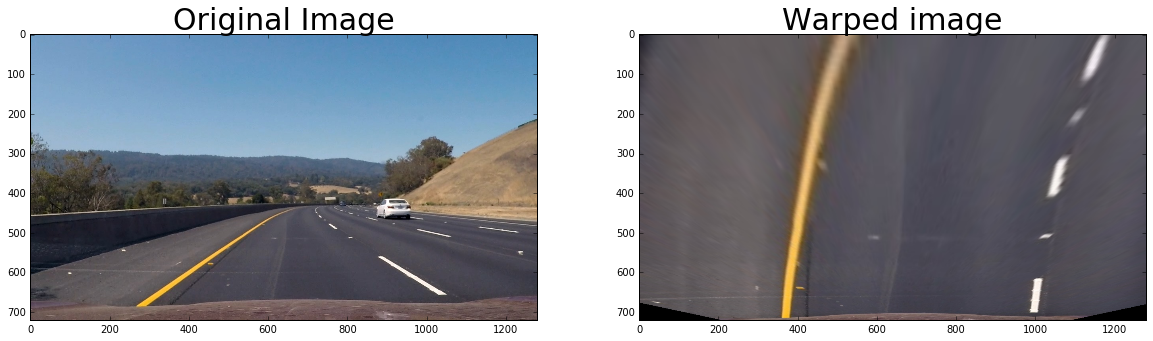

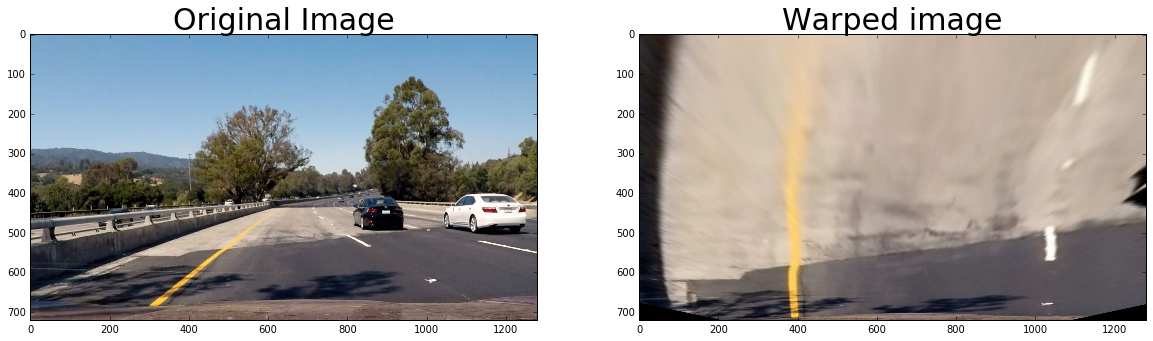

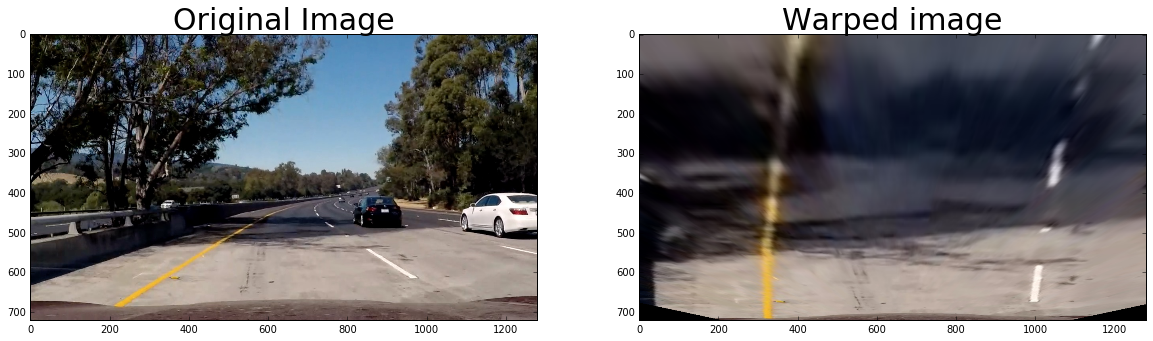

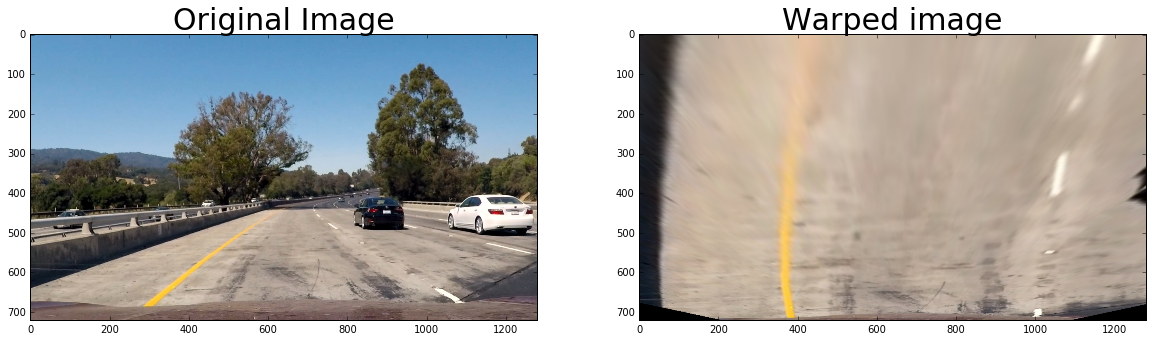

In [129]:
images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    undistorted_image = undistort_image(image, mtx, dist)
    warped_image = warp_perspective(undistorted_image, M)
    plot_two_images_side_by_side(image, warped_image, 'Original Image', 'Warped image', cv2.COLOR_BGR2RGB)

In [117]:
def sobelx_threshold(img, thresh_min = 20, thresh_max = 100):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def sobely_threshold(img, thresh_min = 20, thresh_max = 100):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)

    # Sobel y
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) # Take the derivative in y
    abs_sobely = np.absolute(sobely) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobely/np.max(abs_sobely))

    # Threshold x gradient
    sybinary = np.zeros_like(scaled_sobel)
    sybinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sybinary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

def b_threshold(img, thresh_min = 128, thresh_max = 255):

    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    
    b_channel = lab[:,:,2]
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= thresh_min) & (b_channel <= thresh_max)]  = 1
    
    return b_binary

def yc_threshold(img, thresh_min = 128, thresh_max = 255):
    ycbcr = lab = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    
    yc_channel = ycbcr[:,:,0]
    yc_binary = np.zeros_like(yc_channel)
    yc_binary[(yc_channel >= thresh_min) & (yc_channel <= thresh_max)]  = 1
    return yc_binary

def apply_all_thresholds(image):
    img = np.copy(image)

    sx_binary = sobelx_threshold(img, 20, 100)
    sy_binary = sobely_threshold(img, 20, 100)
    #sy_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(40, 100))
    b_binary = b_threshold(img, 150, 255)
    yc_binary = yc_threshold(img, 210, 255)
  
    
    combined_binary = np.zeros_like(s_binary)
    combined_binary[(sx_binary == 1) | (sy_binary == 1) | (b_binary == 1) | (yc_binary == 1)] = 1
    
    return combined_binary, sx_binary, sy_binary, b_binary, yc_binary

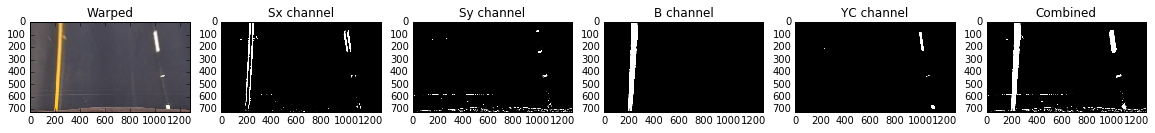

In [118]:
calib_image_name = 'test_images/straight_lines1.jpg'
image = cv2.imread(calib_image_name)
undistort_img = undistort_image(image, mtx, dist)
warped_image = warp_perspective(undistort_img, M)

combined_binary, sx_binary, sy_binary, b_binary, yc_binary = apply_all_thresholds(warped_image)
#combined_binary = (combined_binary.copy() * 255).astype('uint8')

images=[cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB), sx_binary, sy_binary, b_binary, yc_binary, combined_binary]
titles = ['Warped', 'Sx channel', 'Sy channel', 'B channel', 'YC channel', 'Combined']
cmaps = [cv2.COLOR_BGR2RGB, 'gray', 'gray', 'gray', 'gray', 'gray']
plot_images_side_by_side(images, titles, cmaps)


    

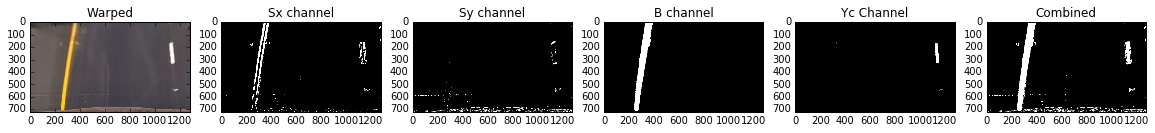

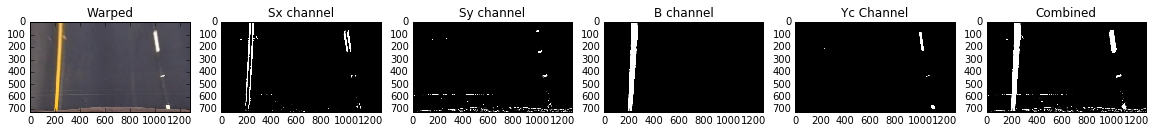

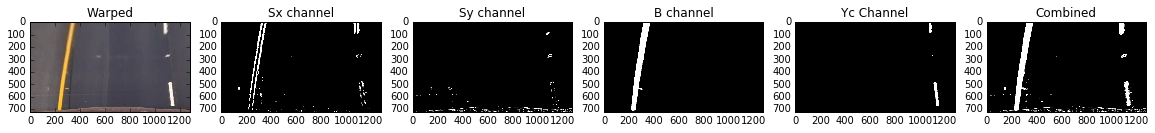

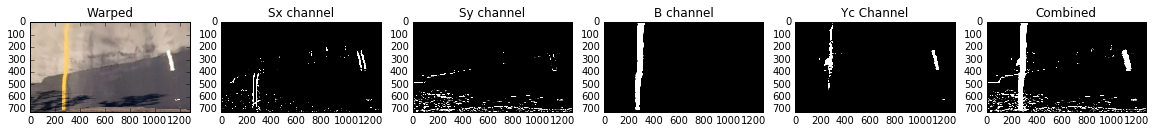

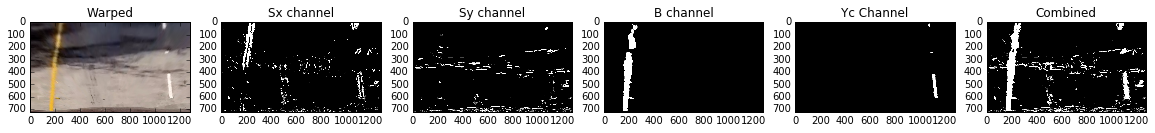

In [119]:
images = glob.glob('test_images/*.jpg')
images_plot = []
titles = ['Warped', 'Sx channel', 'Sy channel', 'B channel', 'Yc Channel', 'Combined']
cmaps = [cv2.COLOR_BGR2RGB, 'gray', 'gray', 'gray', 'gray', 'gray']
for idx, fname in enumerate(images):
    image = cv2.imread(fname)
    undistorted_image = undistort_image(image, mtx, dist)
    warped_image = warp_perspective(undistorted_image, M) 
    combined_binary, sx_binary, sy_binary, b_binary, yc_binary = apply_all_thresholds(warped_image)  
    images_plot=[cv2.cvtColor(warped_image, cv2.COLOR_BGR2RGB), sx_binary, sy_binary, b_binary, yc_binary, combined_binary]
    plot_images_side_by_side(images_plot, titles, cmaps)